# DataJoint tutorial
Jan 2024

Vyom Raval

Before running our imports, make sure your docker container is running with the terminal command `docker-compose up -d`

In [1]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import glob
import dj_metadata as djm

import pandas as pd
import sys
import spikeoutputs as so
import spikeplots as sp

[2024-01-08 17:19:35,539][INFO]: Connecting root@127.0.0.1:3306
[2024-01-08 17:19:35,723][INFO]: Connected root@127.0.0.1:3306


Let's connect to the datajoint server hosted in our docker container.

In [2]:
dj.config['database.host'] = '127.0.0.1'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'simple'

In [3]:
dj.conn()

DataJoint connection (connected) root@127.0.0.1:3306

Load metadata jsons into datajoint tables

In [4]:
# Put path to NAS array json's here
str_metadata_dir = '/Volumes/data-1/data/metadata/json/'
# str_metadata_dir = '/Volumes/Vyom MEA/data/metadata/json/'

In [5]:
djm.load_metadata(str_metadata_dir)

Added 0 new experiments


# Datatables.
We have 5 main DataTables linked in a hierarchy:

Experiment -> Protocol -> EpochBlock -> SortingChunk -> CellTyping

Let's fetch the Experiment table as a pandas dataframe and see what it looks like

In [6]:
djm.Experiment().fetch(format='frame').head()

,animal_id
date_id,
20220406C,
20220412C,
20220420C,
20220426C,
20220518,


Nice, it's a list of date IDs for each MEA experiment. The animal_id field hasn't been populated yet.

Let's look at the protocol datatable and query it for the fast noise protocol

In [7]:
(djm.Protocol() & f'protocol_id="manookinlab.protocols.FastNoise"').fetch(format='frame').head()

,,n_groups,n_blocks
date_id,protocol_id,,
20220406C,manookinlab.protocols.FastNoise,2,19
20220412C,manookinlab.protocols.FastNoise,1,17
20220420C,manookinlab.protocols.FastNoise,2,21
20220426C,manookinlab.protocols.FastNoise,2,18
20220518,manookinlab.protocols.FastNoise,2,8


This is nice but can be tedious to find the full protocol id.

Let's use the `search_protocol` method to search this column with a substring and return all matches.

In [8]:
ls_protocols = djm.search_protocol('movingbar')
print(ls_protocols)

['manookinlab.protocols.MovingBar', 'manookinlab.protocols.MovingBarColorAdapt', 'manookinlab.protocols.MovingBarSpeedTuning']


Let's now input these protocol IDs to `chunk_id_protocol` to get all the metadata.

In [9]:
df_meta = djm.chunk_id_protocol(ls_protocols)
df_meta

chunk_id  \
date_id   protocol_id                                data_file            
20230322C manookinlab.protocols.MovingBarSpeedTuning data007     chunk1   
                                                     data019     chunk3   
20230530C manookinlab.protocols.MovingBarColorAdapt  data006     chunk1   
20230613C manookinlab.protocols.MovingBarColorAdapt  data005     chunk1   
20230614C manookinlab.protocols.MovingBarColorAdapt  data006     chunk1   
20230621C manookinlab.protocols.MovingBarColorAdapt  data008     chunk1   
20230713C manookinlab.protocols.MovingBar            data018     chunk1   
                                                     data023     chunk1   
                                                     data029     chunk2   
20230725C manookinlab.protocols.MovingBarColorAdapt  data005     chunk1   
20230808C manookinlab.protocols.MovingBarColorAdapt  data005     chunk1   

                                                                                     group_label  
date_id   protocol_id                                data_file                                    
20230322C manookinlab.protocols.MovingBarSpeedTuning data007    moving bar speed tuning scotopic  
                                                     data019    moving bar speed tuning photopic  
20230530C manookinlab.protocols.MovingBarColorAdapt  data006                       chromatic bar  
20230613C manookinlab.protocols.MovingBarColorAdapt  data005                    moving bar adapt  
20230614C manookinlab.protocols.MovingBarColorAdapt  data006                    moving bar adapt  
20230621C manookinlab.protocols.MovingBarColorAdapt  data008                         color adapt  
20230713C manookinlab.protocols.MovingBar            data018                  Mesopic Moving Bar  
                                                     data023                          Moving Bar  
                                                     data029                 Scotopic Moving Bar  
20230725C manookinlab.protocols.MovingBarColorAdapt  data005              moving bar color adapt  
20230808C manookinlab.protocols.MovingBarColorAdapt  data005              moving bar color adapt

## Loading cell typing

Now we want to see the mosaics for these experiments. Let's load the cell typing text files from analysis dir.

In [10]:
# Analysis directory with structure analysis/data_id/chunk_id/algo/typing_filename.txt
str_analysis_dir = '/Volumes/data-1/analysis/'

In [11]:
djm.load_typing(str_analysis_dir, verbose=False)

Error in 20230228C chunk1 data000_data001 /Volumes/data-1/analysis/20230228C/chunk1/kilosort2/kilosort2.ak.classification.txt
the number of columns changed from 2 to 3 at row 382; use `usecols` to select a subset and avoid this error
Error in 20230228C chunk1 data000_data001 /Volumes/data-1/analysis/20230228C/chunk1/kilosort2/kilosort2.ak.classification.old.txt
the number of columns changed from 2 to 3 at row 651; use `usecols` to select a subset and avoid this error


Some typing text files give errors due to formatting. 

We can ignore for now and use `make_df_celltyping` to construct a dataframe with typing info.

In [12]:
df_ct = djm.make_df_celltyping(df_meta)

In [13]:
df_ct

num_cells  \
date_id   protocol_id                     data_file chunk_id data_files      algorithm b_typing_file_exists typing_file                                                     
20230322C manookinlab.protocols.FastNoise data005   chunk1   data005_data006 kilosort2 1                    /Volumes/data-1/analysis/20230322C/chunk1/kilos...        879   
                                                                                                            /Volumes/data-1/analysis/20230322C/chunk1/kilos...        879   
20230613C manookinlab.protocols.FastNoise data000   chunk1   data000         kilosort2 1                    /Volumes/data-1/analysis/20230613C/chunk1/kilos...        424   
                                                                                                            /Volumes/data-1/analysis/20230613C/chunk1/kilos...        424   

                                                                                                                                                                num_goodcells  \
date_id   protocol_id                     data_file chunk_id data_files      algorithm b_typing_file_exists typing_file                                                         
20230322C manookinlab.protocols.FastNoise data005   chunk1   data005_data006 kilosort2 1                    /Volumes/data-1/analysis/20230322C/chunk1/kilos...            879   
                                                                                                            /Volumes/data-1/analysis/20230322C/chunk1/kilos...            879   
20230613C manookinlab.protocols.FastNoise data000   chunk1   data000         kilosort2 1                    /Volumes/data-1/analysis/20230613C/chunk1/kilos...            424   
                                                                                                            /Volumes/data-1/analysis/20230613C/chunk1/kilos...            424   

                                                                                                                                                                num_on_p  \
date_id   protocol_id                     data_file chunk_id data_files      algorithm b_typing_file_exists typing_file                                                    
20230322C manookinlab.protocols.FastNoise data005   chunk1   data005_data006 kilosort2 1                    /Volumes/data-1/analysis/20230322C/chunk1/kilos...       186   
                                                                                                            /Volumes/data-1/analysis/20230322C/chunk1/kilos...       186   
20230613C manookinlab.protocols.FastNoise data000   chunk1   data000         kilosort2 1                    /Volumes/data-1/analysis/20230613C/chunk1/kilos...         0   
                                                                                                            /Volumes/data-1/analysis/20230613C/chunk1/kilos...         0   

                                                                                                                                                                num_off_p  \
date_id   protocol_id                     data_file chunk_id data_files      algorithm b_typing_file_exists typing_file                                                     
20230322C manookinlab.protocols.FastNoise data005   chunk1   data005_data006 kilosort2 1                    /Volumes/data-1/analysis/20230322C/chunk1/kilos...          0   
                                                                                                            /Volumes/data-1/analysis/20230322C/chunk1/kilos...          0   
20230613C manookinlab.protocols.FastNoise data000   chunk1   data000         kilosort2 1                    /Volumes/data-1/analysis/20230613C/chunk1/kilos...          0   
                                                                                                            /Volumes/data-1/analysis/20230613C/chunk1/kilos...  

Some typing files have 0 under num_on_p etc. This is because the associated cell type label (OnP) is not present in the typing file.

## Plotting mosaics.

Let's use my SpikeOutputs class and spikeplots module to take all our metadata and load the associated data from the NAS array.

In [14]:
def create_data_objs(df_meta, df_ct, algo='kilosort2'):
    # Move multiindex to columns
    df_meta = df_meta.reset_index()
    df_ct = df_ct.reset_index()

    # Create SpikeOutputs objects for each date-chunk pair with a valid typing file.
    d_data_objs = {}
    
    # Iterate through all date_id and chunk_id in df_ct
    df_ct = df_ct[df_ct['algorithm']==algo]

    dates = df_ct['date_id'].unique()
    for date_id in dates:
        chunks = df_ct[df_ct['date_id']==date_id]['chunk_id'].unique()

        for chunk_id in chunks:
            typing_files = df_ct[(df_ct['date_id']==date_id) & (df_ct['chunk_id']==chunk_id)]['typing_file'].unique()

            for idx_t, typing_file in enumerate(typing_files):
                # Get sum of num_on_p etc for each typing file
                mask = (df_ct['date_id']==date_id) & (df_ct['chunk_id']==chunk_id) & (df_ct['typing_file']==typing_file)
                n_cells = df_ct[mask].loc[:, 'num_on_p':].values.sum()
                if n_cells==0:
                    print(f"ERROR: {typing_file} has no cell types corresponding to defined labels")
                else:
                    file_names = df_meta[(df_meta['date_id']==date_id) & (df_meta['chunk_id']==chunk_id)]['data_file'].values
                    
                    d_paths =  {
                    "str_experiment": date_id,
                    
                    "ls_filenames": list(file_names),
                    "paramsfile": os.path.join(str_analysis_dir, f"{date_id}/{chunk_id}/kilosort2/kilosort2.params"),
                    "paramsmatfile": '',#os.path.join(str_analysisdir,f"{date_id}/{chunk_id}/kilosort2/kilosort2_params.mat"),
                    "dataset_name": algo,
                    "str_algo": algo,
                    "str_chunk": chunk_id,
                    
                    "str_classification": typing_file,

                    "str_protocol": "noise"
                    }

                    data = so.SpikeOutputs(**d_paths)
                    data.load_sta()
                    
                    str_key = f'{date_id}_{chunk_id}_{idx_t}'
                    d_data_objs[str_key] = data
    return d_data_objs

In [15]:
d_data_objs = create_data_objs(df_meta, df_ct, algo='kilosort2')

ERROR: /Volumes/data-1/analysis/20230613C/chunk1/kilosort2/goodids.txt has no cell types corresponding to defined labels
ERROR: /Volumes/data-1/analysis/20230613C/chunk1/kilosort2/kilosort2.classification.txt has no cell types corresponding to defined labels


In [16]:
d_data_objs.keys()

dict_keys(['20230322C_chunk1_0', '20230322C_chunk1_1'])

[array([<AxesSubplot: title={'center': 'OnM (n=253) RFs'}>,
        <AxesSubplot: title={'center': 'OnP (n=186) RFs'}>], dtype=object),
 array([<AxesSubplot: title={'center': 'OnM (n=253) timecourses'}>,
        <AxesSubplot: title={'center': 'OnP (n=186) timecourses'}>],
       dtype=object)]

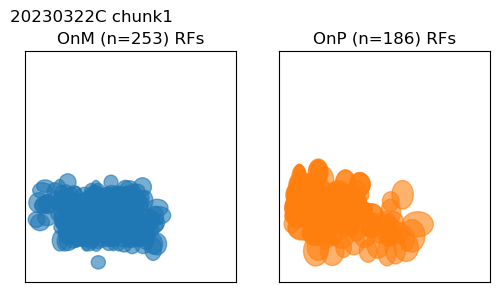

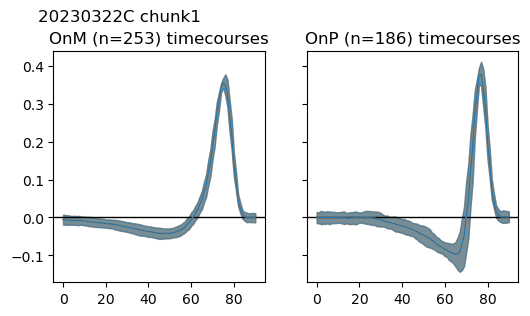

In [17]:
data = d_data_objs['20230322C_chunk1_0']
sp.plot_type_rfs_and_tcs(data)

## Loading PSTHs

Now we can use the `load_psth` function which uses symphony_data methods to load the PSTH!

In [18]:
str_protocol = 'movingbar'
ls_param_names = ['orientation', 'speed', 'contrast', 'barSize']
bin_rate = 100.0
data.load_psth(str_protocol, ls_param_names, bin_rate)

Processing group 1 of 1 and block 1 of 1


In [19]:
# Get the common cell IDs between whitenoise and movingbar
data.set_common_ids()

Number of common cells: 854
Out of 186 OnP cells, 182 are common.
Out of 253 OnM cells, 253 are common.


We now have everything we need for further analysis!

In [20]:
data.stim['unique_params']

{'orientation': array([0]),
 'speed': array([ 500, 1000, 2000, 4000]),
 'contrast': array([-1,  1]),
 'barSize': array([ 200, 3000])}

In [21]:
data.print_stim_summary()

epoch length: 7000.0 ms
Total epochs: 96
pre: 250.0 ms; stim: 6500.0 ms; tail: 250.0 ms
pre pts: 25; stim pts: 650; tail pts: 25
bin rate: 100.0 Hz; bin dt: 10.0 ms


For instance, let's plot OnP PSTHs when speed was 500

In [22]:
n_speed = 500
epoch_mask = np.where(np.array(data.stim['params']['speed'])==n_speed)
print(f'Number of trials with speed {n_speed} = {len(epoch_mask[0])}')

Number of trials with speed 500 = 24


In [23]:
data.spikes['spike_dict'][1].shape

(96, 700)

Text(0.5, 1.0, 'On Parasol PSTH for speed 500')

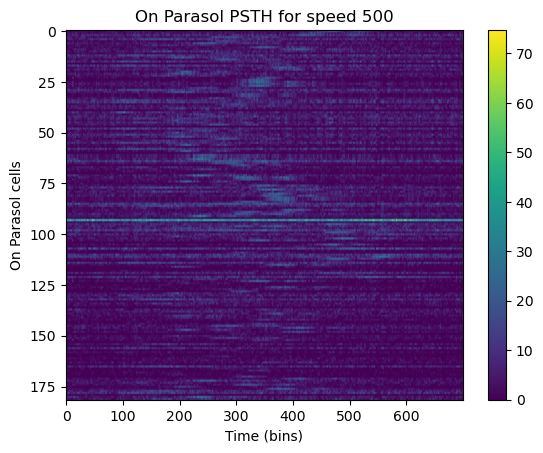

In [24]:
onp_ids = data.types.d_main_IDs['OnP']

onp_psth = [data.spikes['spike_dict'][onp_id][epoch_mask].mean(axis=0) for onp_id in onp_ids]
onp_psth = np.array(onp_psth)

plt.imshow(onp_psth, aspect='auto')
plt.colorbar()
plt.xlabel('Time (bins)')
plt.ylabel('On Parasol cells')
plt.title(f'On Parasol PSTH for speed {n_speed}')